The US National Oceanic and Atmospheric Administration (NOAA) publishes climate data through the National Centers for Environmental Information (NCEI), with daily measurements called the [Global \[Surface\] Summary of Day (GSOD)](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516). Per this page, "The data are reported and summarized based on Greenwich Mean Time (GMT, 0000Z - 2359Z) since the original synoptic/hourly data are reported and based on GMT." 

The data is available in many forms, including raw CSV [here](https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/). This is organized by year, and then by a file per data-collecting station. The stations are identified by a combination of USAF (Air Force station ID) and WBAN (NCDC (National Climatic Data Center) Weather Bureau Army Navy number) identifiers. These stations are further located by latitude and longitude in this stations list file: [https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv) (and in [txt](https://www.ncei.noaa.gov/pub/data/noaa/isd-history.txt) format)

I want to do analysis on climate data for Chicago year over year, so I want to find a station in the Chicago area with the greatest year-over-year coverage of data (maximum days per year of data). 

More details about the formats of these GSOD data files can be found in the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt).

Taking the latitude/longitude of the approximate center of Chicago per [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Chicago,_Illinois#:~:text=Chicago%20is%20a%20city%20in,%C2%B039%E2%80%B254.00%E2%80%B3%20West.) as `(41.868, -87.665)`, we can find the closest station using the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) for great circle distances. 

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
28239  998499  99999                      NORTHERLY ISLAND   US    IL   NaN   
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
27689  997255  99999                 9087044 - CALUMET  IL   US   NaN   NaN   
27765  997338  99999                               CHICAGO   US    IL   NaN   
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   
21634  744665   4838              PALWAUKEE MUNICIPAL ARPT   US    IL  KPWK   
20057  725337   4807                  GARY/CHICAGO AIRPORT   US    IN  KGYY   
18063  722126   4879                  LANSING MUNICIPAL AP   US    IL  KIGQ   
20070  725348   4831              LEWIS UNIVERSITY AIRPORT   US    IL  KLOT   
20028  725305  94892                        DUPAGE AIRPORT   US    IL  KDPA   

          LAT     LON  ELEV(M)     BEGIN       END  distance_to_chicago  \
28239  41.856 -87.609    190.0  20120618  20231209     

<Axes: xlabel='LON', ylabel='LAT'>

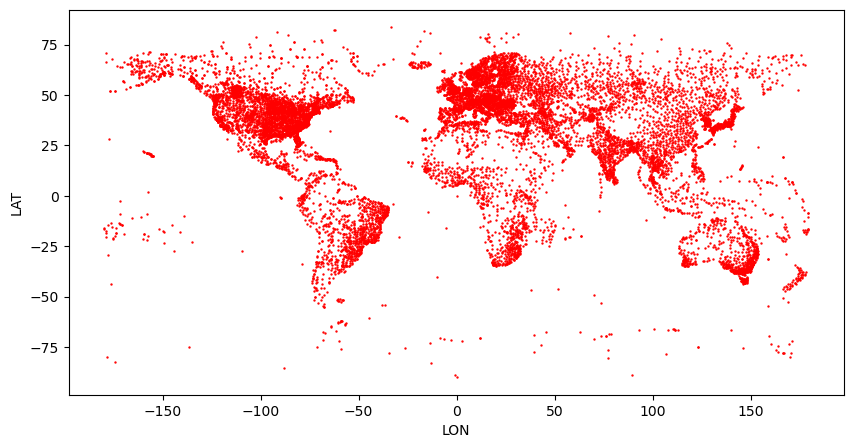

In [1]:
import pandas as pd
from haversine import haversine
import requests
import datetime
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

def distanceToChicago(station):
    chicagoLatLong = (41.868, -87.665)
    return haversine((station['LAT'], station['LON']), chicagoLatLong)

def daysExpected(station):
    begin = datetime.datetime.strptime(station['BEGIN'], '%Y%m%d')
    end = datetime.datetime.strptime(station['END'], '%Y%m%d')
    return (end - begin).days

stations = pd.read_csv('https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv', dtype={'BEGIN': 'string', 'END': 'string'})
stations.dropna(subset=['LAT', 'LON'], inplace=True)
stations['distance_to_chicago'] = stations.apply(distanceToChicago, axis=1)
stations['days_expected'] = stations.apply(daysExpected, axis=1)
stations['begin_year'] = stations['BEGIN'].str.slice(0, 4)
stations['end_year'] = stations['END'].str.slice(0, 4)
stations.sort_values('distance_to_chicago', inplace=True)
# I'm really only interested in stations with current data
stations = stations[stations['end_year'].str.contains('2023')]
print(stations.head(10))

stations.plot(x='LON', y='LAT', kind='scatter', s=0.5, c='red')

Visually inspecting this, I see the two stations with the highest date coverage and the closest distance to Chicago are "CHICAGO MIDWAY INTL ARPT" and "CHICAGO O'HARE INTERNATIONAL AIRPORT".

Later we'll need to confirm quality and coverage of data with the actual data files.

In [2]:
chicagoStations = stations[stations['STATION NAME'].isin(['CHICAGO MIDWAY INTL ARPT', 'CHICAGO O\'HARE INTERNATIONAL AIRPORT'])]
print(chicagoStations)

         USAF   WBAN                          STATION NAME CTRY STATE  ICAO  \
20060  725340  14819              CHICAGO MIDWAY INTL ARPT   US    IL  KMDW   
20027  725300  94846  CHICAGO O'HARE INTERNATIONAL AIRPORT   US    IL  KORD   

          LAT     LON  ELEV(M)     BEGIN       END  distance_to_chicago  \
20060  41.784 -87.755    185.8  19730101  20231210             11.95220   
20027  41.960 -87.932    204.8  19461001  20231210             24.34657   

       days_expected begin_year end_year  
20060          18605       1973     2023  
20027          28194       1946     2023  


In [3]:
def checkUrlExists(url):
    try:
        # By only sending an HTTP HEAD request, we don't consume bandwidth 
        # by actually requesting the whole resource. We just check that it responds.
        response = requests.head(url)
        return response.status_code  == requests.codes.ok
    except requests.ConnectionError:
        print(f"Failed to connect to {url}.")
        return False

def gsodUrl(station, year):
    usaf, wban = station['USAF'], station['WBAN']
    return f"https://www.ncei.noaa.gov/data/global-summary-of-the-day/access/{year}/{usaf}{wban}.csv"

def checkAllDataExists(station):
    allExists = True
    beginYear, endYear = map(int, [station['begin_year'], station['end_year']])
    for year in range(beginYear, endYear + 1):
        requestUrl = gsodUrl(station, year)
        if checkUrlExists(requestUrl):
            # print(f"Data exists for year {year} at {requestUrl}")
            pass
        else:
            print(f"WARNING: Missing data for year {year} at {requestUrl}")
            allExists = False
    if allExists:
        print(f"All data files for years {beginYear} to {endYear} exist!")
    return allExists

# Let's check each of the Chicago stations to make sure we have all the data we expect:
for station in chicagoStations.iloc:
    name = station['STATION NAME']
    print(f"Checking that data exists for {name}")
    checkAllDataExists(station)

Checking that data exists for CHICAGO MIDWAY INTL ARPT
All data files for years 1973 to 2023 exist!
Checking that data exists for CHICAGO O'HARE INTERNATIONAL AIRPORT


Oh no! There are missing data files for years 1970, 1971, and 1972 for the "CHICAGO O'HARE INTERNATIONAL AIRPORT" station. This won't do. Interestingly, this data is available when going through [this page](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094846/detail), but the files apparently aren't present in this GSOD CSV format. 

I'll just use the "CHICAGO MIDWAY INTL ARPT" station then and satisfy myself with data from 1973 to present day. Based on the BEGIN/END dates in the original station index file, I'm expecting to see 18587 days of data whereas the actual data we get back from GSOD has 18546 days worth of measurements, leaving a discreprancy of 41 days. The cause of this discrepancy may be in how the Python `timedelta` object calculates difference of two dates ([https://docs.python.org/3/library/datetime.html#timedelta-objects](https://docs.python.org/3/library/datetime.html#timedelta-objects)).  

In [4]:
def getAllData(station):
    beginYear, endYear = station['begin_year'], station['end_year']
    name = station['STATION NAME']
    data = []
    print(f"Downloading data for {name} from {beginYear} to {endYear}")
    for year in range(int(beginYear), int(endYear) + 1):
        requestUrl = gsodUrl(station, year)
        print(f"Downloading data for year {year} ({requestUrl})")
        data.append(pd.read_csv(requestUrl, dtype={'FRSHTT': 'string'}))
    return pd.concat(data)
    
station = stations[stations['STATION NAME'] == 'CHICAGO MIDWAY INTL ARPT'].iloc[0]
gsod = getAllData(station)

## Discarding Unused Data

According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt), the values contained in this file are the following:


| FIELD            | VALUE FOR MISSING | DESCRIPTION                                                                     |
| ---------------- | ----------------- | ------------------------------------------------------------------------------- |
| STATION          |                   | Station number (WMO/DATSAV3 possibly combined w/WBAN number)                    |
| DATE             |                   | Given in mm/dd/yyyy format                                                      |
| LATITUDE         |                   | Given in decimated degrees (Southern Hemisphere values are negative)            |
| LONGITUDE        |                   | Given in decimated degrees (Western Hemisphere values are negative)             |
| ELEVATION        |                   | Given in meters                                                                 |
| NAME             |                   | Name of station/airport/military base                                           |
| TEMP             | 9999.9            | Mean temperature for the day in degrees Fahrenheit to tenths.                   |
| TEMP_ATTRIBUTES  |                   | Number of observations used in calculating mean temperature.                    |
| DEWP             | 9999.9            | Mean dew point for the day in degrees Fahrenheit to tenths.                     |
| DEWP_ATTRIBUTES  |                   | Number of observations used in calculating mean dew point.                      |
| SLP              | 9999.9            | Mean sea level pressure for the day in millibars to tenths.                     |
| SLP_ATTRIBUTES   |                   | Number of observations used in calculating mean sea level pressure.             |
| STP              | 9999.9            | Mean station pressure for the day in millibars to tenths.                       |
| STP_ATTRIBUTES   |                   | Number of observations used in calculating mean station pressure.               | 
| VISIB            | 999.9             | Mean visibility for the day in miles to tenths.                                 |
| VISIB_ATTRIBUTES |                   | Number of observations used in calculating mean visibility.                     |  
| WDSP             | 999.9             | Mean wind speed for the day in knots to tenths.                                 |
| WDSP_ATTRIBUTES  |                   | Number of observations used in calculating mean wind speed.                     |
| MXSPD            | 999.              | Maximum sustained wind speed reported for the day in knots to tenths.           |
| GUST             | 999.9             | Maximum wind gust reported for the day in knots to tenths.                      |
| MAX              | 9999.9            | Maximum temperature reported during the day in Fahrenheit to tenths. Note: Time of maximum temperature report varies by country and region, so this will sometimes not be the maximum for the calendar day.  |   
| MAX_ATTRIBUTES   |                   | Blank indicates maximum temperature was taken from the explicit maximum temperature report and not from the 'hourly' data.  * indicates maximum temperature was derived from the hourly data (i.e. highest hourly or synoptic-reported temperature). |
| MIN              | 9999.9            | Minimum temperature reported during the day in Fahrenheit to tenths. Note: Time of minimum temperature report varies by country and region, so this will sometimes not be the maximum for the calendar day. |
| MIN_ATTRIBUTES   |                   | Blank indicates minimum temperature was taken from the explicit minimum temperature report and not from the 'hourly' data. * indicates minimum temperature was derived from the hourly data (i.e. highest hourly or synoptic-reported temperature). |
| PRCP             | 99.99             | Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation (i.e. may include latter part of previous day). “0” indicates no measurable precipitation (includes a trace). Note: Many stations do not report “0” on days with no precipitation, therefore “99.99” will often appear on these days. Also, for example, a station may only report a 6-hour amount for the period during which rain fell. See attribute field for source of data. |
| PRCP_ATTRIBUTES  |                   | A = 1 report of 6-hour precipitation amount. B = Summation of 2 reports of 6-hour precipitation amount. C = Summation of 3 reports of 6-hour precipitation amount. D = Summation of 4 reports of 6-hour precipitation amount. E = 1 report of 12-hour precipitation amount. F = Summation of 2 reports of 12-hour precipitation amount. G = 1 report of 24-hour precipitation amount. H = Station reported '0' as the amount for the day (eg, from 6-hour reports), but also reported at least one occurrence of precipitation in hourly observations. This could indicate a trace occurred, but should be considered as incomplete data for the day. I = Station did not report any precipitation data for the day and did not report any occurrences of precipitation in its hourly observations. It's still possible that precipitation occurred but was not reported. |
| SNDP             | 999.9             | Snow depth in inches to tenths. It is the last report for the day if reported more than once. Note: Most stations do not report “0” on days with no snow on the ground, therefore, “999.9” will often appear on these days. |
| FRSHTT           |                   | Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of: Fog ('F' - 1st digit). / Rain or Drizzle ('R' - 2nd digit). / Snow or Ice Pellets ('S' - 3rd digit). / Hail ('H' - 4th digit). / Thunder ('T' - 5th digit). / Tornado or Funnel Cloud ('T' - 6th digit). |

I'm not going to dive into all of the ATTRIBUTES values for quality of data, I'm just going to use the measurements at face value. I also don't care about storing the STATION ID, the ELEVATION, LATITUDE, or LONGITUDE which will just take up space unnecessarily. So I'll constrain the data to just the columns I do want to keep:

In [5]:
gsod = gsod[['DATE', 'NAME', 'TEMP', 'MIN', 'MAX', 'DEWP', 'PRCP', 'SNDP', 'FRSHTT', 'GUST', 'WDSP', 'MXSPD', 'SLP', 'STP']]
print(gsod)

           DATE                           NAME  TEMP   MIN   MAX  DEWP  PRCP  \
0    1973-01-01  CHICAGO MIDWAY AIRPORT, IL US  25.2  19.9  30.0  15.5  0.00   
1    1973-01-02  CHICAGO MIDWAY AIRPORT, IL US  22.0  14.0  32.0  12.5  0.00   
2    1973-01-03  CHICAGO MIDWAY AIRPORT, IL US  29.3  21.9  39.0  22.4  0.00   
3    1973-01-04  CHICAGO MIDWAY AIRPORT, IL US  27.0  17.1  41.0  22.4  0.63   
4    1973-01-05  CHICAGO MIDWAY AIRPORT, IL US  11.5   8.1  16.0   2.5  1.38   
..          ...                            ...   ...   ...   ...   ...   ...   
338  2023-12-05  CHICAGO MIDWAY AIRPORT, IL US  38.1  33.8  42.1  32.4  0.02   
339  2023-12-06  CHICAGO MIDWAY AIRPORT, IL US  36.4  32.0  39.0  27.6  0.06   
340  2023-12-07  CHICAGO MIDWAY AIRPORT, IL US  42.1  35.6  52.0  32.1  0.00   
341  2023-12-08  CHICAGO MIDWAY AIRPORT, IL US  50.2  45.0  55.9  39.6  0.00   
342  2023-12-09  CHICAGO MIDWAY AIRPORT, IL US  54.0  53.1  55.0  46.4  0.00   

      SNDP  FRSHTT   GUST  WDSP  MXSPD 

Let's break out the `FRSHTT` column into individually named columns for ease of use. This indicates some helpful binary flags about presence of notable weather conditions:

```
FRSHTT - Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of:
                         Fog ('F' - 1st digit).
                         Rain or Drizzle ('R' - 2nd digit).
                         Snow or Ice Pellets ('S' - 3rd digit).
                         Hail ('H' - 4th digit).
                         Thunder ('T' - 5th digit).
                         Tornado or Funnel Cloud ('T' - 6th digit).
```

In [6]:
gsod['FOG']     = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('100000', 2)))
gsod['RAIN']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('010000', 2)))
gsod['SNOW']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('001000', 2)))
gsod['HAIL']    = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000100', 2)))
gsod['THUNDER'] = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000010', 2)))
gsod['TORNADO'] = gsod['FRSHTT'].apply(lambda s: bool(int(s, 2) & int('000001', 2)))
gsod = gsod.drop(columns=['FRSHTT'])

# For the `SNDP` and `PRCP` values, if there is no snow accumulation or rain precipitation 
# then 999.9 or 99.99 (respectively) may appear as a value. For my purposes, it would be
# more helpful if these showed up as 0.
gsod.loc[gsod['SNDP'] == 999.9, 'SNDP'] = 0
gsod.loc[gsod['PRCP'] == 99.99, 'PRCP'] = 0

We have some erroneous values for `MIN` and `MAX`. According to the [README](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt) these columns each have values to indicate missing data:

| Column | Missing Value Indicator |
| ------ | ----------------------- |
| MIN    | 9999.9                  |
| MAX    | 9999.9                  |

I want to use these values in my visualizations, so it's pretty important these exist. Let's look at what days they're missing for:

In [7]:
gsod[(gsod['MIN'] == 9999.9) | (gsod['MAX'] == 9999.9)]

,DATE,NAME,TEMP,MIN,MAX,DEWP,PRCP,SNDP,GUST,WDSP,MXSPD,SLP,STP,FOG,RAIN,SNOW,HAIL,THUNDER,TORNADO
117,1977-04-28,"CHICAGO MIDWAY AIRPORT, IL US",48.0,37.9,9999.9,37.3,0.31,0.0,23.9,14.1,17.1,1013.5,991.0,True,True,False,False,True,False
202,1982-07-22,"CHICAGO MIDWAY AIRPORT, IL US",66.7,9999.9,82.9,59.4,0.00,0.0,999.9,7.8,12.8,9999.9,999.9,True,True,False,False,False,False
322,1985-11-20,"CHICAGO MIDWAY AIRPORT, IL US",30.0,20.1,9999.9,19.6,0.00,0.0,40.0,17.0,25.1,9999.9,999.9,True,True,False,False,False,False
7,1989-01-08,"CHICAGO MIDWAY AIRPORT, IL US",23.1,12.2,9999.9,12.9,0.00,0.0,29.9,17.8,25.1,9999.9,999.9,True,False,True,False,False,False
349,2008-12-15,"CHICAGO MIDWAY AIRPORT, IL US",21.0,6.1,9999.9,17.7,0.18,0.0,35.9,16.1,24.1,1023.4,997.5,False,True,True,False,False,False
94,2016-04-04,"CHICAGO MIDWAY AIRPORT, IL US",40.4,33.1,9999.9,28.1,0.00,0.0,31.1,16.0,22.0,1014.4,993.5,False,True,True,False,False,False


Phew! Only 6 days with missing `MIN` or `MAX` values. I'll discard those days since I'm going to be relying on those values for a lot of my visualizations. 

In [10]:
gsod = gsod[(gsod['MIN'] < 9999.9) & (gsod['MAX'] < 9999.9)]

gsod['DATE'] = pd.to_datetime(gsod['DATE'])
gsod['YEAR'] = gsod['DATE'].dt.year
gsod['MONTH'] = gsod['DATE'].dt.month
gsod['DAY_OF_MONTH'] = gsod['DATE'].dt.day
gsod['DAY_OF_YEAR'] = gsod['DATE'].dt.dayofyear

Text(0.5, 1.0, 'Snow Depth (0 - 5 in)')

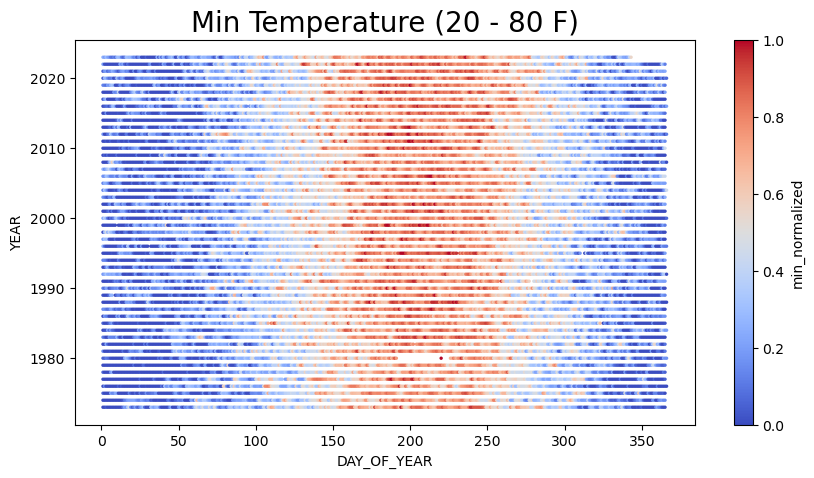

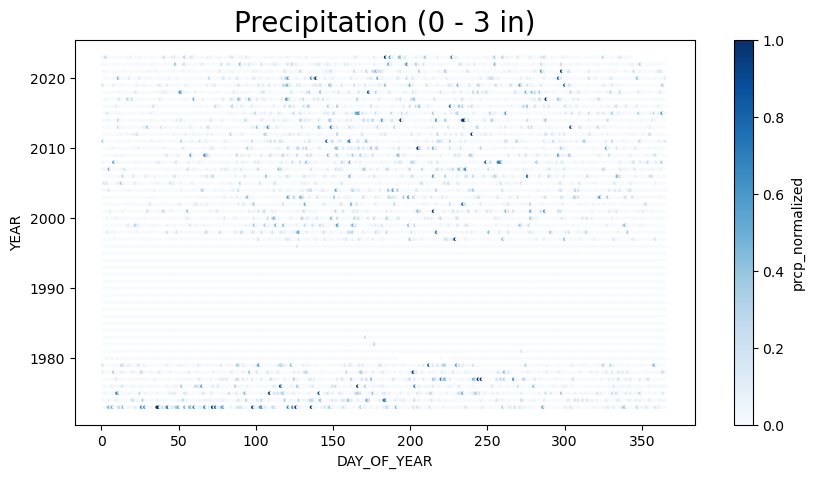

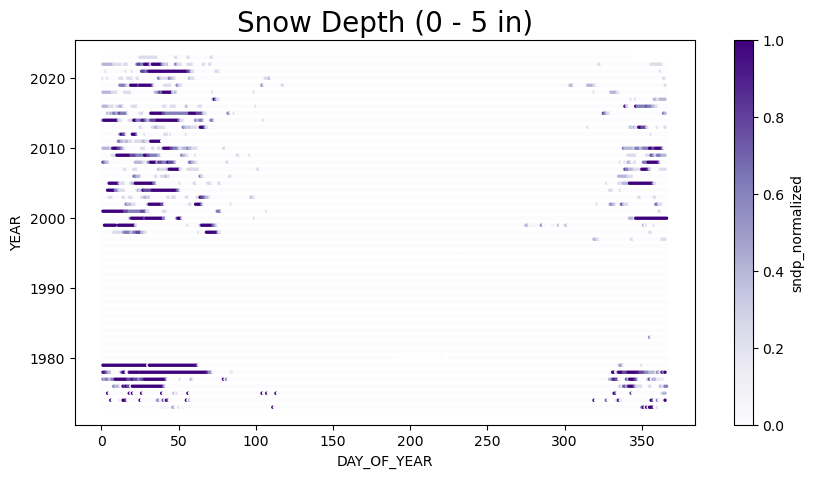

In [12]:
def normalize(day, value, min, max):
    normalized = (day[value] - min) / (max - min)
    if normalized < 0.0:
        normalized = 0.0
    if normalized > 1.0:
        normalized = 1.0
    return normalized
gsod['min_normalized'] = gsod.apply(lambda m: normalize(m, 'MIN', 20, 80), axis=1)
gsod['prcp_normalized'] = gsod.apply(lambda m: normalize(m, 'PRCP', 0, 3), axis=1)
gsod['sndp_normalized'] = gsod.apply(lambda m: normalize(m, 'SNDP', 0, 5), axis=1)
gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c='min_normalized', colormap='coolwarm').set_title('Min Temperature (20 - 80 F)', fontsize=20)
gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c='prcp_normalized', colormap='Blues').set_title('Precipitation (0 - 3 in)', fontsize=20)
gsod.plot(x='DAY_OF_YEAR', y='YEAR', kind='scatter', s=2, c='sndp_normalized', colormap='Purples').set_title('Snow Depth (0 - 5 in)', fontsize=20)

## Weather Questions

I've got some 🔥BURNING🔥 questions about the trends of weather in Chicago, and especially about our decline into 🥶COLD DAYS🥶. 

1. How often have we had snowfall on Christmas? How much was there?
2. How often has it been above 40℉ on Christmas?
3. How often have we had Decembers where the temperature reaches at least 50℉ for more than one day in a row? How long is that streak?
4. What's the last day in December when the temperature was at least 50℉?
5. For each year, and for each month of the winter, what was the biggest temperature differential in a 2-day period?
6. As we approach winter, it feels like it sharply declines from warm temperatures (> 70℉) to cold temperatures (< 32℉). When does the first sub-freezing (< 32℉) temperature happen each Fall/Winter, and how long before that day was it still warm (> 70℉)?
7. Every year it feels like we have a very short Fall in Chicago, which I would characterize as a time during which the temperatures exist between 32℉ and 70℉. How long do the temperatures exist in this range?
8. When's the last Fall day (after September 22) when the temperature is at least 70℉?
9. When's the first Fall day (after September 22) that the temperature drops to below freezing?
10. When's the first Fall day (after September 22) that the temperature never gets above freezing?

Having grown up in Doylestown, Pennsylvania I'm used to different winter weather. I want to also compare all of these answers to what has historically happened around my hometown and see if really is harsher in Chicago or if that's just my imagination.

### 1. How often have we had snowfall on Christmas? How much was there?

In [36]:
gsod[(gsod['MONTH'] == 12) & (gsod['DAY_OF_MONTH'] == 25) & gsod['SNOW'] & (gsod['SNDP'] > 0)][['DATE', 'SNDP']]

,DATE,SNDP
358,1977-12-25,2.0
358,1978-12-25,0.8
358,2002-12-25,3.1
358,2005-12-25,1.2
359,2008-12-25,5.1
358,2009-12-25,1.2
358,2010-12-25,7.1
358,2017-12-25,2.0


Out of 50 years, we've only had 8 years where there was accumulated snow on Christmas! 

In 2010 and 2008 we had very significant snowfall on Christmas. We haven't had snow on Christmas since 2017. 

### 2. How often has it been above 40℉ on Christmas?

In [47]:
gsod[(gsod['MONTH'] == 12) & (gsod['DAY_OF_MONTH'] == 25) & (gsod['MAX'] > 40)][['DATE', 'MAX']]

,DATE,MAX
358,1973-12-25,44.6
358,1978-12-25,41.0
358,1979-12-25,52.0
358,1982-12-25,62.1
358,1987-12-25,46.9
355,1991-12-25,42.1
358,1994-12-25,50.9
358,2006-12-25,43.0
358,2007-12-25,42.1
358,2009-12-25,43.0


### 3. How often have we had Decembers where the temperature reaches at least 50℉ for more than one day in a row? How long is that streak?

In [48]:
min_temp = 50
warm_days_by_year = gsod[(gsod['MONTH'] == 12) & (gsod['MAX'] >= min_temp)].groupby('YEAR')
for year, data in warm_days_by_year:
    longest_streak = 1
    current_streak = 1
    for i in range(1, len(data)):
        if data.iloc[i]['DAY_OF_MONTH'] == data.iloc[i - 1]['DAY_OF_MONTH'] + 1:
            current_streak += 1
        else:
            longest_streak = current_streak
            current_streak = 1
    print(f"Longest streak of >={min_temp}℉ for {year}: {longest_streak} days")

Longest streak of >=50℉ for 1973: 1 days
Longest streak of >=50℉ for 1975: 3 days
Longest streak of >=50℉ for 1976: 1 days
Longest streak of >=50℉ for 1977: 1 days
Longest streak of >=50℉ for 1979: 3 days
Longest streak of >=50℉ for 1980: 1 days
Longest streak of >=50℉ for 1982: 3 days
Longest streak of >=50℉ for 1984: 1 days
Longest streak of >=50℉ for 1985: 1 days
Longest streak of >=50℉ for 1987: 1 days
Longest streak of >=50℉ for 1988: 1 days
Longest streak of >=50℉ for 1990: 1 days
Longest streak of >=50℉ for 1991: 3 days
Longest streak of >=50℉ for 1992: 1 days
Longest streak of >=50℉ for 1993: 1 days
Longest streak of >=50℉ for 1994: 1 days
Longest streak of >=50℉ for 1995: 1 days
Longest streak of >=50℉ for 1996: 1 days
Longest streak of >=50℉ for 1997: 1 days
Longest streak of >=50℉ for 1998: 1 days
Longest streak of >=50℉ for 1999: 4 days
Longest streak of >=50℉ for 2001: 1 days
Longest streak of >=50℉ for 2002: 2 days
Longest streak of >=50℉ for 2003: 1 days
Longest streak o

### 4. What's the last day in December when the temperature was at least 50℉?

In [46]:
print(f"Last day in December with max temperature >= {min_temp}℉")
for year, data in warm_days_by_year:
    print(f"{data.iloc[-1]['YEAR']}, December {data.iloc[-1]['DAY_OF_MONTH']}: {data.iloc[-1]['MAX']}℉")

Last day in December with max temperature >= 50℉
1973, December 5: 55.4℉
1975, December 15: 66.0℉
1976, December 20: 54.0℉
1977, December 18: 60.1℉
1979, December 25: 52.0℉
1980, December 8: 53.1℉
1982, December 28: 61.0℉
1984, December 29: 64.9℉
1985, December 1: 50.0℉
1987, December 9: 54.0℉
1988, December 20: 57.0℉
1990, December 29: 50.0℉
1991, December 13: 60.1℉
1992, December 31: 52.9℉
1993, December 10: 52.0℉
1994, December 27: 52.0℉
1995, December 3: 57.9℉
1996, December 24: 50.0℉
1997, December 19: 51.8℉
1998, December 19: 51.8℉
1999, December 9: 53.6℉
2001, December 6: 64.4℉
2002, December 31: 55.9℉
2003, December 10: 55.4℉
2004, December 31: 57.2℉
2006, December 31: 59.0℉
2007, December 23: 52.0℉
2008, December 28: 54.0℉
2009, December 2: 50.0℉
2010, December 31: 55.9℉
2011, December 19: 51.1℉
2012, December 20: 50.0℉
2013, December 28: 51.1℉
2014, December 27: 51.1℉
2015, December 24: 57.9℉
2016, December 26: 55.0℉
2017, December 19: 51.1℉
2018, December 28: 54.0℉
2019, Dec

### 5. For each year, and for each month of the winter, what was the biggest temperature differential in a 2-day period?

In [56]:
# First let's get just the data for winter months, which we'll consider to be December - March
winter = gsod[gsod['MONTH'].isin([12, 1, 2, 3])].groupby(['YEAR', 'MONTH'])
for (year, month), group in winter:
    max_positive_diff = 0
    max_negative_diff = 0
    for i in range(1, len(group)):
        if group.iloc[i]['MAX'] - group.iloc[i-1]['MIN'] > max_positive_diff:
            max_positive_diff = group.iloc[i]['MAX'] - group.iloc[i-1]['MIN']
        if group.iloc[i]['MIN'] - group.iloc[i-1]['MAX'] < max_negative_diff:
            max_negative_diff = group.iloc[i]['MIN'] - group.iloc[i-1]['MAX']
    print(f"{month}/{year}")
    print(f"Max positive differential: {max_positive_diff}")
    print(f"Max negative differential: {max_negative_diff}")

1/1973
Max positive differential: 30.1
Max negative differential: -32.9
2/1973
Max positive differential: 23.9
Max negative differential: -29.0
3/1973
Max positive differential: 35.099999999999994
Max negative differential: -30.0
12/1973
Max positive differential: 34.9
Max negative differential: -32.4
1/1974
Max positive differential: 43.6
Max negative differential: -36.4
2/1974
Max positive differential: 41.0
Max negative differential: -34.0
3/1974
Max positive differential: 44.099999999999994
Max negative differential: -41.9
12/1974
Max positive differential: 31.200000000000003
Max negative differential: -27.9
1/1975
Max positive differential: 27.0
Max negative differential: -58.2
2/1975
Max positive differential: 38.0
Max negative differential: -35.1
3/1975
Max positive differential: 41.1
Max negative differential: -37.900000000000006
12/1975
Max positive differential: 39.900000000000006
Max negative differential: -43.0
1/1976
Max positive differential: 36.0
Max negative differentia

## First Fall day where the minimum temperature was < 32 F

In [57]:
minFreezingDays = gsod[(gsod['MIN'] < 32) & (gsod['MONTH'] > 8)]
# Group by YEAR and get the first DAY_OF_MONTH and MONTH values for each group
result1 = minFreezingDays.groupby('YEAR').agg({'MONTH': 'first', 'DAY_OF_MONTH': 'first'}).reset_index()

print(result1)

    YEAR  MONTH  DAY_OF_MONTH
0   1973     11             5
1   1974     10             2
2   1975     11            13
3   1976     10            22
4   1977     11            11
5   1978     10            24
6   1979     10            26
7   1980     10             5
8   1981     10            23
9   1982     10            23
10  1983     11             5
11  1984     11             2
12  1985     11            21
13  1986     11             2
14  1987     10            12
15  1988     10            13
16  1989     11             3
17  1990     11             8
18  1991     11             2
19  1992     10            19
20  1993     10            31
21  1994     11            19
22  1995     11             3
23  1996     10            31
24  1997     10            28
25  1998     11             7
26  1999     10            24
27  2000     11            11
28  2001     11            20
29  2002     11             1
30  2003     11             7
31  2004     10            17
32  2005  

## First Fall day where the maximum temperature was < 32 F (the whole day was below freezing)

In [58]:
maxFreezingDays = gsod[(gsod['MAX'] < 32) & (gsod['MONTH'] > 8)]
# Group by YEAR and get the first DAY_OF_MONTH and MONTH values for each group
result2 = maxFreezingDays.groupby('YEAR').agg({'MONTH': 'first', 'DAY_OF_MONTH': 'first'}).reset_index()

print(result2)

    YEAR  MONTH  DAY_OF_MONTH
0   1973     12            11
1   1974     12            18
2   1975     12             1
3   1976     11            29
4   1977     11            27
5   1978     12             9
6   1979     12             1
7   1980     12             3
8   1981     11            21
9   1982     11            13
10  1983     11            30
11  1984     12             4
12  1985     12             2
13  1986     11            12
14  1987     12            16
15  1988     12             1
16  1989     11            18
17  1990     12            23
18  1991     11             3
19  1992     12             5
20  1993     11            29
21  1994     12            11
22  1995     11            12
23  1996     11            12
24  1997     11            16
25  1998     12            22
26  1999     12            21
27  2000     11            21
28  2001     12            24
29  2002     11            25
30  2003     12            12
31  2004     12            14
32  2005  

## Last Fall day where the maximum temperature was > 70 F

In [59]:
maxWarmDays = gsod[(gsod['MAX'] > 70) & (gsod['MONTH'] > 8)]
# Group by YEAR and get the first DAY_OF_MONTH and MONTH values for each group
result3 = maxWarmDays.groupby('YEAR').agg({'MONTH': 'last', 'DAY_OF_MONTH': 'last'}).reset_index()

print(result3)

    YEAR  MONTH  DAY_OF_MONTH
0   1973     10            25
1   1974     11             3
2   1975     11            18
3   1976     10            13
4   1977     11             4
5   1978     11             6
6   1979     11             1
7   1980     10            16
8   1981     10            30
9   1982     10             8
10  1983     10            28
11  1984     10            28
12  1985     10            24
13  1986     10            22
14  1987     11             3
15  1988     10            16
16  1989     11            14
17  1990     11            15
18  1991     10            29
19  1992     10            24
20  1993     10            25
21  1994     10            22
22  1995     10            23
23  1996     10            17
24  1997     10            13
25  1998     10            27
26  1999     11            18
27  2000     11             1
28  2001     11             7
29  2002     10            12
30  2003     10            30
31  2004     10            30
32  2005  